# Dimensionality Reduction

In [2]:
from src.preprocessing import load_data, get_statistics, fill_empty_values
from src.outlier import interquartile_range
from src.visualize import get_histograms, get_boxplot, get_clients_map
from src.normalize import normalize, check_norm, centering
from pathlib import Path
from src.decomposition import svd, get_svd_info, get_errors, low_rank_approx, get_coefficient_matrix
import numpy as np
from src.distance_metric import pairwise_minkowski_distance
from src.decomposition import multidimensional_scaling

In [3]:
data_path = Path('data')
file_path = data_path / '23MAG_HW_1_v1.xls'

In [4]:
dataset = load_data(file_path)

In [5]:
get_statistics(dataset)

,Statistic,Age,Number of dependents,Salary,Years of stay in the region,Car price,Amount of credit
0,Mean,39.298507,2.086957,19861.764706,10.101449,20852.941176,198492.537313
1,Median,38.000000,2.000000,20250.000000,9.000000,20500.000000,200000.000000
2,Std,8.700427,0.996156,10169.342711,4.932321,10692.813469,99837.348500
3,Quantile (25%),34.000000,1.000000,11125.000000,7.000000,12000.000000,118000.000000
4,Quantile (50%),38.000000,2.000000,20250.000000,9.000000,20500.000000,200000.000000
5,Quantile (75%),46.000000,3.000000,27125.000000,14.000000,28000.000000,265500.000000


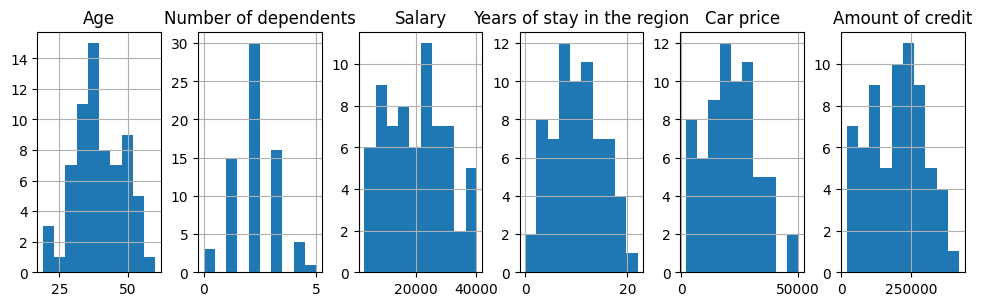

In [6]:
get_histograms(dataset)

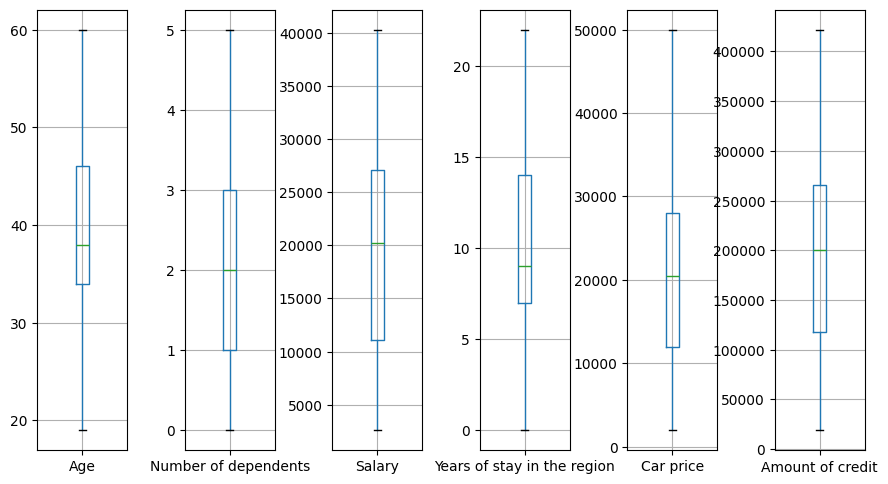

In [7]:
get_boxplot(dataset)

Fill empty values by `mean` value to prevent distribution changes

In [8]:
dataset = fill_empty_values(dataset)

To perform outlier removal `Interquartile Range` is offered

In [9]:
dataset = interquartile_range(dataset)

In [10]:
data_z = normalize(dataset)
matrix_z = data_z.to_numpy()
check_norm(data_z), data_z.describe()

(                   Column_name  Euclidean norm
 0                          Age             1.0
 1         Number of dependents             1.0
 2                       Salary             1.0
 3  Years of stay in the region             1.0
 4                    Car price             1.0
 5             Amount of credit             1.0,
              Age  Number of dependents     Salary  \
 count  70.000000             70.000000  70.000000   
 mean    0.117289              0.109073   0.107227   
 std     0.023165              0.049228   0.053183   
 min     0.059700              0.000000   0.013962   
 25%     0.102237              0.066619   0.060815   
 50%     0.116415              0.106590   0.106658   
 75%     0.133579              0.159886   0.144319   
 max     0.161191              0.213181   0.216412   
 
        Years of stay in the region  Car price  Amount of credit  
 count                    70.000000  70.000000         70.000000  
 mean                      0.108239   0.1

## Principal Component Analysis

In [11]:
matrix_u, singular_values, matrix_v = svd(matrix_z)
get_svd_info(singular_values)

,0
Singular values,"[2.33, 0.69, 0.23, 0.17, 0.11, 0.08]"
Total variance,6.0
Explained variances,"[0.9, 0.08, 0.01, 0.0, 0.0, 0.0]"
Explained variance (via 1 components),0.9
Explained variance (via 2 components),0.98
Explained variance (via 3 components),0.99
Explained variance (via 4 components),1.0
Explained variance (via 5 components),1.0


Note our data could be explained via 2 components which reflect 98% of our feature space.

Therefore in the next steps we will use decomposition rank equal to 2. 

In [12]:
decomposition_rank = 2 

In [13]:
approximated_matrix_z = low_rank_approx(matrix_u, singular_values, matrix_v, precision=decomposition_rank)
get_errors(matrix_z, approximated_matrix_z)

,Error,Result
0,Frobenius norm error,0.098293
1,Spectral norm error,0.226129
2,Relative Frobenius norm error,0.016382


Here we construct `approximate_matrix_z` using the matrixs `u`, `v` and the `singular values` from SVD decomposition of the `marix_z`. In particular, we use only two main factors, which find in the privious step.

After computation of approximate_matrix_z we give an error estimations in different norms (e.g. Forbenius and Spectral norm). The result of the approximation in the norms are quite suitable. 

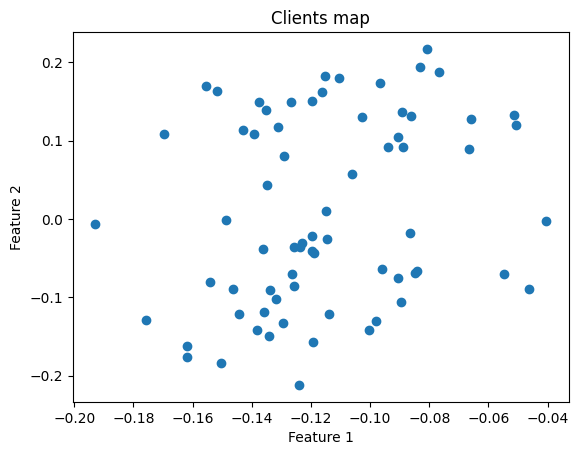

In [14]:
embeddings_pca = matrix_u[:,:decomposition_rank]
get_clients_map(embeddings_pca)

`Feature 1` as we can see below has a large positive correlation with `salary` feature and large negative correlation with `age` and `amount of credit` features. Therefore we can assume that than larger is `Feature 1` the larger is `salary` and less are `age` and `amount of credit`.

`Feature 2` as we can see below has enough small correlation with the our features, but largest negative correlation is observed with `salary` feature. It means that than larger `Feature 2` the less `salary`.

## Hidden Factors Interpretation

$Z_j = (S_1 * V_{j,1} * U_1) + (S_2 * V_{j,2} * U_2)$

In [15]:
coefficient_matrix = get_coefficient_matrix(matrix_z, singular_values, matrix_v, decomposition_rank)
approximated_matrix = matrix_u[:,:2] @ coefficient_matrix

coefficient_matrix

array([[-0.96569145,  0.68512228,  1.47517412, -0.88354544,  0.3416023 ,
        -0.97308397],
       [-0.28589612,  0.2330643 , -0.36059198,  0.28593158,  0.23559037,
        -0.27574837]])

In this step we calculate the coefficients of main factors (principal component) influence on the our features. In firts row we see the coefficient correlation between $U_1$ and $Z_j$, $j=1,\ldots, 6$. In the second row we can see the coefficient correlation between $U_2$ and $Z_j$, $j=1, \ldots, 6$. 

As result `coefficient_matrix` in general sence reflects the correlation between vectors $Z_j$ where $j=1, \ldots, num\_features$ and $U_i, i=1,\ldots, decomposition\_rank$

## Dimensionality reduction with MDS

In [16]:
pairwise_minkowski_distance(matrix_z, 2)

array([[0.        , 0.11592734, 0.0180853 , ..., 0.08001579, 0.02671458,
        0.13583065],
       [0.11592734, 0.        , 0.11514281, ..., 0.15182235, 0.12733107,
        0.08668374],
       [0.0180853 , 0.11514281, 0.        , ..., 0.08925094, 0.01429577,
        0.12804378],
       ...,
       [0.08001579, 0.15182235, 0.08925094, ..., 0.        , 0.09476974,
        0.2011015 ],
       [0.02671458, 0.12733107, 0.01429577, ..., 0.09476974, 0.        ,
        0.13400219],
       [0.13583065, 0.08668374, 0.12804378, ..., 0.2011015 , 0.13400219,
        0.        ]])

Here we choose a minkowski distance with $p = 2$ as distance function beetwen vectors representing our clients. It is possible to choose a $p$ differe from $2$. 

11 - It could be consider that task of finding the transition matrix between our space and Euclidean space with dimension equale two. If recieved matrix will reflect isometry transformation, our task will be solved. 

So how we can find transition matrix? Maybe, it is possible to use `coefficient_matrix` recieved above. The next steps enough simple. It is necessary to apply our matrix to some vector in our space as a result we recive a vector of dimension 2. The next step we should calculate the norm beetwen two vectors $$x_1 = [x_1^1, \ldots, x_1^6], x_2 = [x_2^1,\ldots, x_2^6]$$ in our space and the norm beetwen two vectors $$coefficient\_matrix\cdot x_1 = y_1 = [y_1^1, y_1^2]; coefficient\_matrix\cdot x_2 = y_2 = [y_2^1, y_2^2]$$ in Euclidean space of dimension 2. 

If $$||x_1 - x_2|| = ||y_1 - y_2||,$$ we have success.

If the `coefficient_matrix` is not suitable, it is probably to find the matrix, based on basis in our space and basis in Euclidean space of dimension 2.

Stress value: 0.41


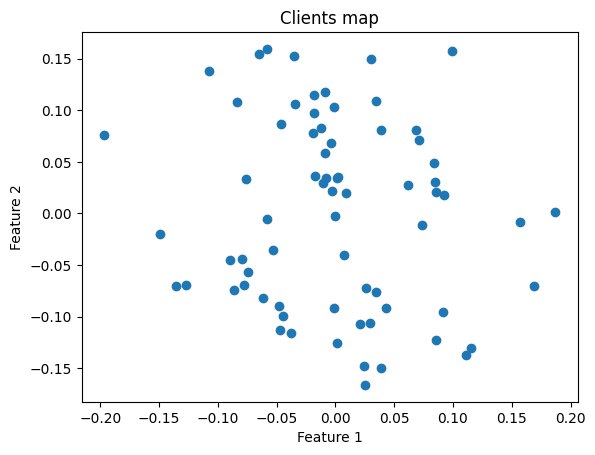

In [17]:
embeddings_mds = multidimensional_scaling(matrix_z, verbose=True)
get_clients_map(embeddings_mds)

We can see that this matrix is the rotated feature map from SVD